In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from collections import Counter

from PIL import Image
from io import BytesIO

warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
from classes.AE import Autoencoder

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


### load data

In [8]:
import cv2

def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                             
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [9]:
images=load_images('data')

### plotting example images

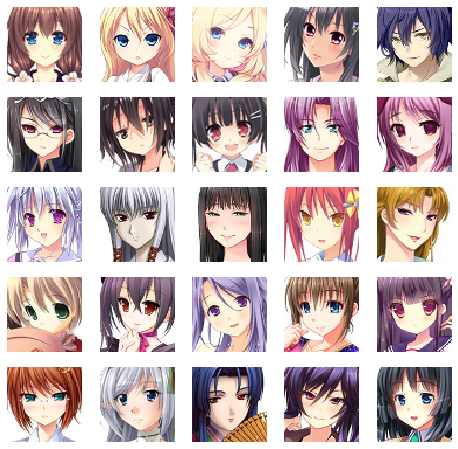

In [10]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [12]:
test = np.array(images)
test.shape

(21551, 64, 64, 3)

### reshaping into arrays for model

In [21]:
# Convert list with images to numpy array and reshape it 
X = np.array(images).reshape(-1, 64, 64, 3)

# Scaling data in array
X = X / 255.0

from sklearn.model_selection import train_test_split

# Splitting data to train and test datasets
X_train, X_test = train_test_split(X, test_size = 0.2, shuffle = True, random_state = 66)

In [22]:
n = int(len(X_test)/2)
X_valid = X_test[:n]
X_test = X_test[n:]

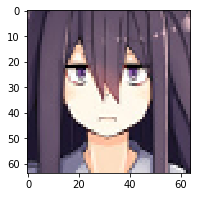

In [24]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

plt.figure(figsize=(3,3))
img =7809
plt.imshow(X[img])

### Defining ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift
                            height_shift_range = 0.15, # Range for vertical shift
                            shear_range = 0.2) # Shear Intensity

datagen.fit(X_train)

### building Autoencoder

In [26]:
AE = Autoencoder(
    input_dim = (64,64,3)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,1,2]
    , decoder_conv_t_filters = [64,64,32,3]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    ### 3 for the last decoder layer as we as we want RGB images
    , decoder_conv_t_strides = [2,1,2,1]
    , z_dim = 200
)

AE._build()

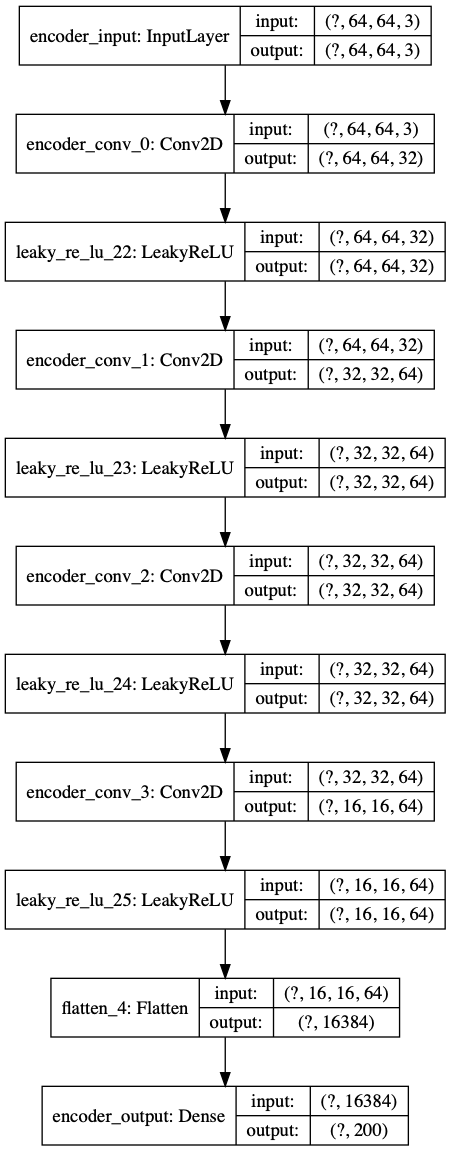

In [27]:
keras.utils.plot_model(AE.encoder, "figures/Autoencoder_encoder_model.png", show_shapes=True)

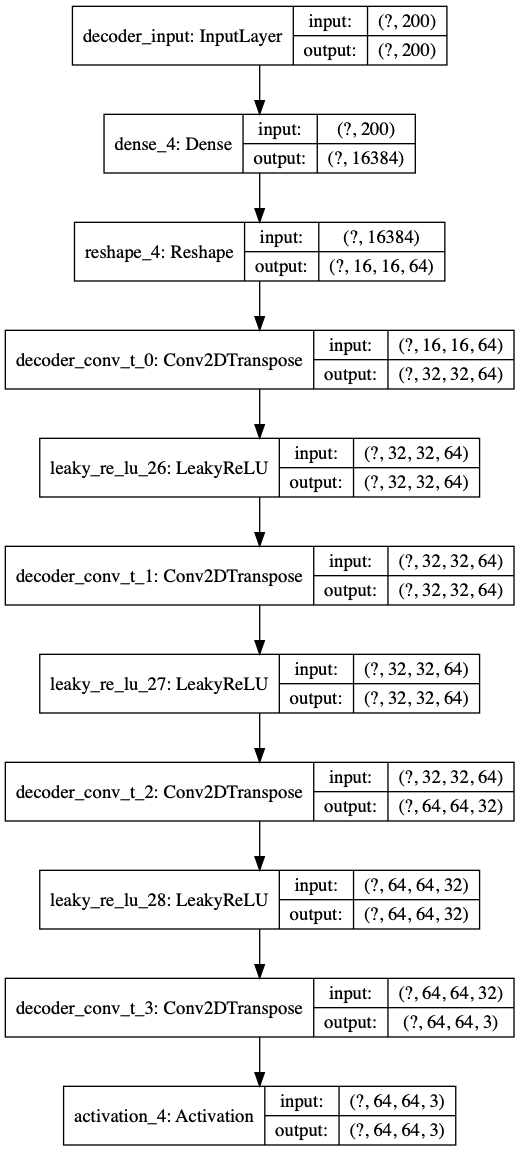

In [28]:
keras.utils.plot_model(AE.decoder, "figures/Autoencoder_decoder_model.png", show_shapes=True)

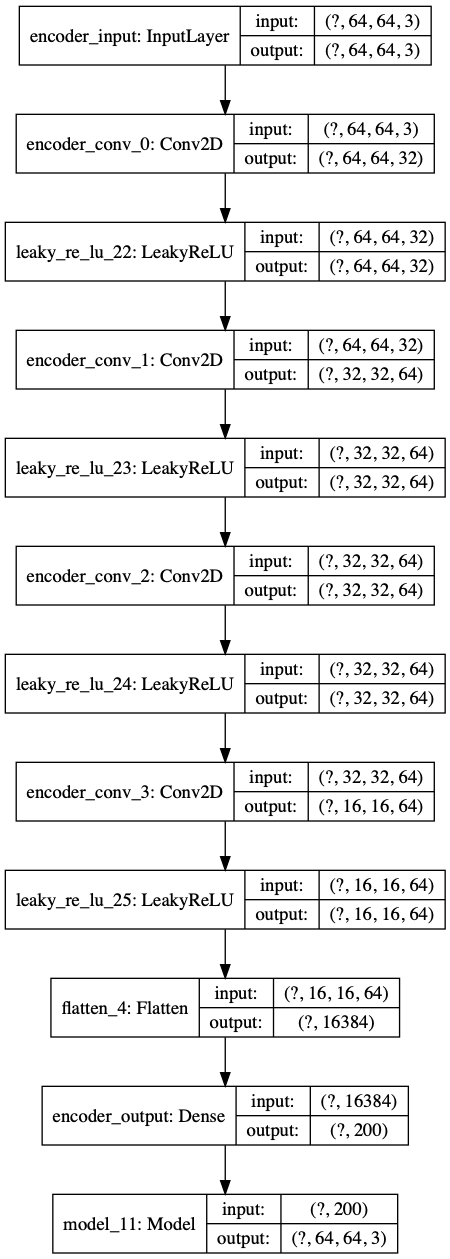

In [29]:
keras.utils.plot_model(AE.model, "figures/Autoencoder_model.png", show_shapes=True)

### compiling and fitting model

In [30]:
LEARNING_RATE = 0.0005

optimizer = Adam(lr=LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

AE.model.compile(optimizer=optimizer, loss = r_loss, metrics = ['accuracy'])

In [31]:
checkpointer = ModelCheckpoint(filepath='saved_models/autoencoder.h5',
                               verbose=2, save_best_only=True)

early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

In [33]:
### note that we are testing with X_train against X_train - we want the autoencoder to be able to reproduce X_train

history = AE.model.fit(X_train, X_train,
                    epochs=100, batch_size=32, verbose=2,
                    validation_data=(X_valid, X_valid),
                    callbacks=[checkpointer, early_stopping_cb])

Train on 17240 samples, validate on 2155 samples
Epoch 1/100
 - 230s - loss: 0.0184 - accuracy: 0.8489 - val_loss: 0.0166 - val_accuracy: 0.8557

Epoch 00001: val_loss improved from 0.02097 to 0.01663, saving model to saved_models/autoencoder.h5
Epoch 2/100
 - 226s - loss: 0.0157 - accuracy: 0.8581 - val_loss: 0.0151 - val_accuracy: 0.8651

Epoch 00002: val_loss improved from 0.01663 to 0.01515, saving model to saved_models/autoencoder.h5
Epoch 3/100
 - 229s - loss: 0.0145 - accuracy: 0.8596 - val_loss: 0.0145 - val_accuracy: 0.8628

Epoch 00003: val_loss improved from 0.01515 to 0.01447, saving model to saved_models/autoencoder.h5
Epoch 4/100
 - 235s - loss: 0.0138 - accuracy: 0.8612 - val_loss: 0.0141 - val_accuracy: 0.8559

Epoch 00004: val_loss improved from 0.01447 to 0.01413, saving model to saved_models/autoencoder.h5
Epoch 5/100
 - 243s - loss: 0.0133 - accuracy: 0.8616 - val_loss: 0.0139 - val_accuracy: 0.8628

Epoch 00005: val_loss improved from 0.01413 to 0.01393, saving mod

### plotting history plot of fitting Autoencoder

In [34]:
def history_plot(history, n):
    tot_pairs = np.int(len(list(history.history.keys()))/2)
    
    plt.figure(figsize=(18,12))
    for i in range(tot_pairs):

        plt.subplot(np.int(tot_pairs)*100+11+np.int(i))
        plt.plot(history.history[list(history.history.keys())[i]][n:],
                                     color='#4876ff', label = list(history.history.keys())[i])
        plt.plot(history.history[list(history.history.keys())[i + tot_pairs]][n:],
                                     color='slategray', label = list(history.history.keys())[i + tot_pairs])
        plt.xlabel("Epochs")
        plt.ylabel(list(history.history.keys())[i+tot_pairs])
        plt.legend()
        plt.grid()
        plt.title(list(history.history.keys())[i+tot_pairs])

    plt.show()

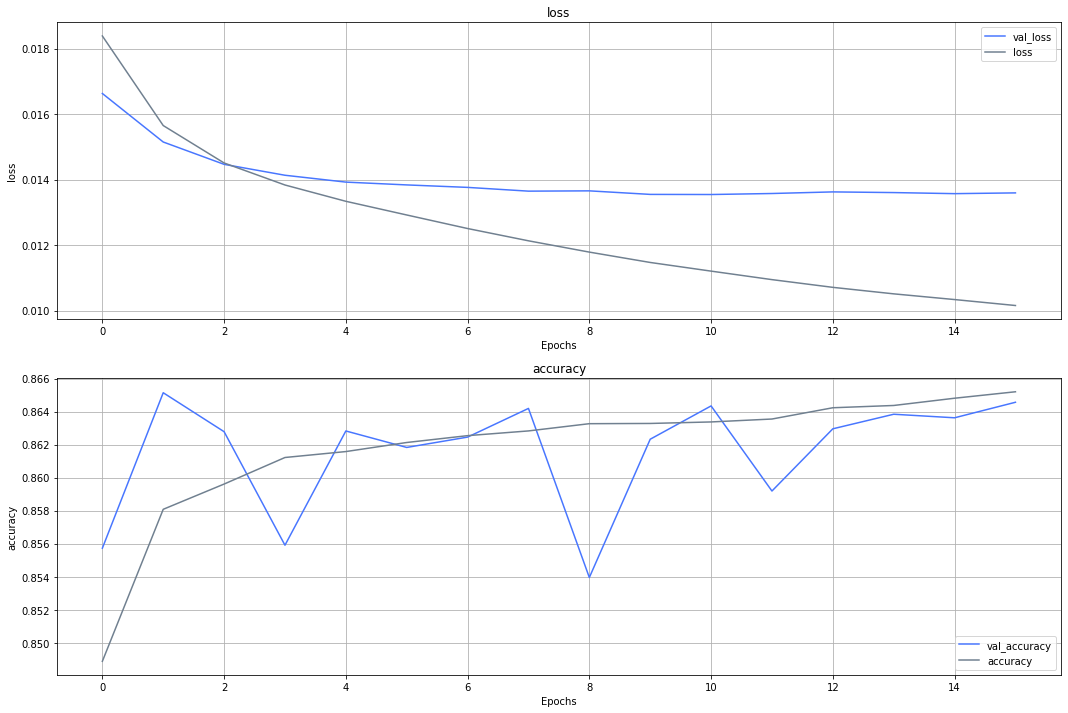

In [36]:
history_plot(history, 0)

### loading model & evaluating test data

In [ ]:
model = keras.models.load_model("save/autoencoder.h5")

In [37]:
score = AE.model.evaluate(X_test, X_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.013318147785021666
Test accuracy: 0.868312656879425


### decoding encoded sample images

In [ ]:
example_idx = np.random.choice(range(len(X)), n_to_show)
example_idx

In [40]:
np.array([12,13])

array([12, 13])

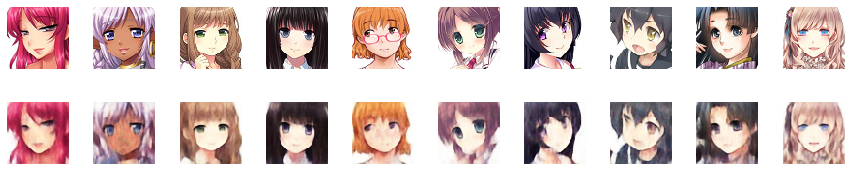

In [46]:
n_to_show = 10
example_idx = np.random.choice(range(len(X)), n_to_show)
example_images = X[example_idx]
#example_images = X[np.array([230, 7809])]

z_points = AE.encoder.predict(example_images)

reconst_images = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    #ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img)

    
plt.savefig('model_images/AE_encoder_decoder_images.png')

### newly generated points

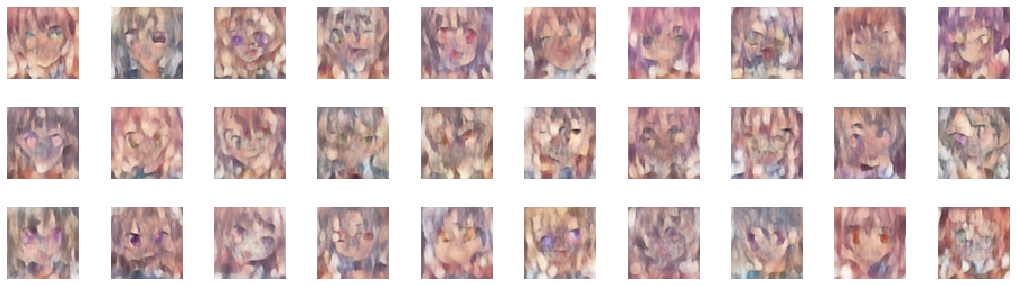

In [48]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show, AE.z_dim))

reconst = AE.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.savefig('model_images/AE_new_images.png')
plt.show()